In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch, torchvision
from torch.utils.data import DataLoader

ModuleNotFoundError: No module named 'torch'

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



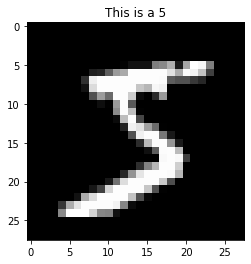

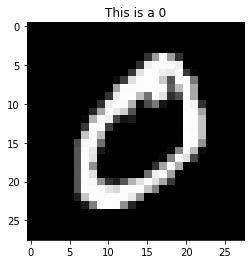

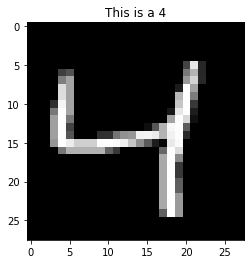

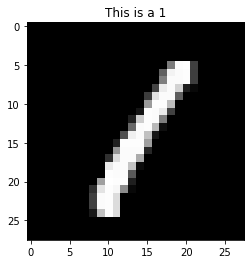

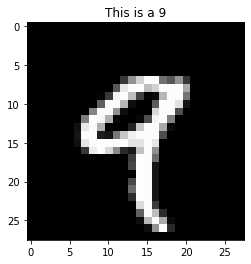

In [2]:
#The MNIST dataset is about 12 MB and will be downloaded automatically if it is not located in the given path.
mnist = torchvision.datasets.MNIST('./', train=True, download=True, transform=torchvision.transforms.ToTensor())

#Helper for visualization
def torch_imshow(img):
    img = img[0]
    plt.imshow(img.cpu().numpy(), cmap='gray')
    plt.show()

#Visualize first 5 samples
for n in range(5):
    sample = mnist[n]
    img, label = sample
    plt.figure()
    plt.title(f'This is a {label}')
    torch_imshow(img)


In [3]:
## Create a dataloader batch size of 16 
## Hint: Check pytorch tutorial page nn.dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(mnist, batch_size=16, shuffle=True)


In [19]:
## Create a 1 layer fully connected network without any activation
##Hint1:Mnist dataset contains 28x28 grayscale images and contains 10 different classes(0 to 9)
##Hint2:You will need to override __init__ and forward function to make network work

class OneLayerNetwork(torch.nn.Module):
    def __init__(self):
      super().__init__()
      self.linear = torch.nn.Linear(28*28, 10)
     
    def forward(self, x):
        return self.linear(x)


In [20]:
one_layer_net = OneLayerNetwork().cuda()

dummy_input = torch.randn(16, 784, device='cuda') #You can create tensors in GPU directly instead of .cuda()
dummy_output = one_layer_net(dummy_input)

print(f'Dummy input shape: {dummy_input.shape}')
print(f'Dummy output shape: {dummy_output.shape}')

Dummy input shape: torch.Size([16, 784])
Dummy output shape: torch.Size([16, 10])


In [21]:
# Define an SGD optimizer with learning rate 0.001 to optimize the parameters of "one_layer_net"
learning_rate = 1e-3
sgd_optimizer =  torch.optim.SGD(one_layer_net.parameters(), lr=learning_rate)
print(sgd_optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [22]:
## Decide which loss function to use from torch.nn module and define it below
# Hint1: The network does 'not' include a softmax activation at the output.
# Hint2: We are doing multi class classification task with 10 parameters.

loss_fn = torch.nn.CrossEntropyLoss()

In [28]:
##Warning: Don't re-run this block multiple times. 
##Running this part will continue to train the model. 
##First, restart the kernel Runtime->restart runtime(or restart and run all), then re-run your code.

loss_list = [] #To plot loss graph later

for train_images, train_labels in train_dataloader:
    ## Move data to GPU
    train_images, train_labels = train_images.cuda(), train_labels.cuda()
    
    ## Flatten the images 
    flat_images = train_images.reshape(-1, 784)
    
    ## Run the network with flattened images 
    class_scores = one_layer_net(flat_images)
    
    ## Calculate loss loss_fn defined with network output and labels from dataset
    loss = loss_fn(class_scores, train_labels)
    loss_list.append(loss)
    
    ## Take an optimization step (don't forget to clear the gradients first)
    ################ FILL HERE ####################################
    # Backpropagation
    # 1-Clear gradients
    sgd_optimizer.zero_grad()

    # 2-Compute gradients using loss
    loss.backward()

    # 3-Take a gradient descent step using optimizer
    sgd_optimizer.step()

    ############################################################### 
    

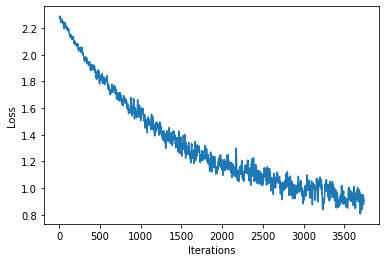

In [29]:
# Helper for plotting the loss graph smoothly. 
def plot_loss_graph(loss_list):
    filter_size = 10
    moving_average_filter = [1/filter_size] * filter_size
    smoothed_loss_list = np.convolve(loss_list, moving_average_filter, 'valid') 
    plt.figure()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(smoothed_loss_list)
    
plot_loss_graph(loss_list)

In [30]:
## Test your network's accuracy on the test set

# Prepare test set
mnist_test = torchvision.datasets.MNIST('./', train=False, download=True, transform=torchvision.transforms.ToTensor())
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=False)


true_predictions = 0
false_predictions = 0
for test_images, test_labels in test_dataloader:
    ## Move batch to GPU
    test_images, test_labels = test_images.cuda(), test_labels.cuda()
    
    ## Flatten the images from [BATCH, 1, 28, 28] to [BATCH, 784]
    flat_images = test_images.reshape(-1, 784)
    
    ## Run the network with flattened images 
    with torch.no_grad():
        class_scores = one_layer_net(flat_images)
    
    ## Extract predictions from class_scores using torch.argmax() method
    class_predictions = torch.argmax(class_scores, axis=-1)
    
    ## Find the number of true predictions in the batch using test_labels and class_predictions
    true_predictions_batch  = torch.sum(class_predictions == test_labels)
    false_predictions_batch = torch.sum(class_predictions != test_labels)
    
    true_predictions  += true_predictions_batch.item()
    false_predictions += false_predictions_batch.item()

accuracy = true_predictions / (true_predictions + false_predictions)
print(f'Accuracy = {accuracy*100}%')
     

Accuracy = 83.84%
